## Inference in non-Gaussian stochastic volatility models

This tutorial demonstrates inference using the Levy [Stable](http://docs.pyro.ai/en/stable/distributions.html#stable) distribution.

In [1]:
import os
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints
from pyro import poutine
from pyro.infer import EnergyDistance, SVI, Trace_ELBO
from pyro.infer.autoguide import (AutoDelta, AutoDiagonalNormal, AutoLowRankMultivariateNormal,
                                  init_to_median)
from pyro.optim import ClippedAdam


%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
%config InlineBackend.figure_formats = ['svg']

In [2]:
df = pd.read_csv(os.path.expanduser("~/Downloads/snp500.csv"))
#df = pd.read_csv(os.path.expanduser("~/Downloads/KO.csv"))

In [3]:
x = torch.tensor(df["Close"]).float()
# torch.save(x, os.path.expanduser("~/Downloads/snp500_daily_open.pkl"))

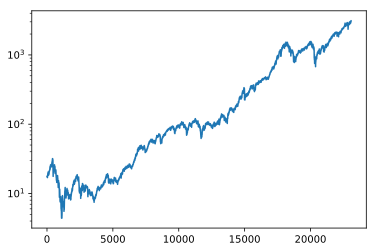

In [4]:
pyplot.plot(x)
pyplot.yscale('log')

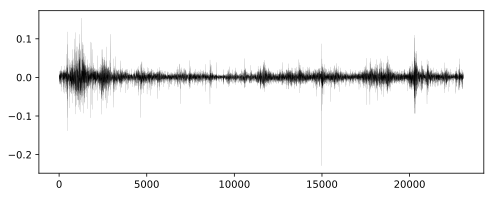

In [5]:
pyplot.figure(figsize=(8, 3), dpi=300)
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1);

mean = 0.00022394036932382733
std = 0.011869287118315697


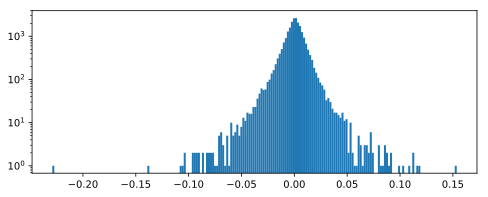

In [6]:
pyplot.figure(figsize=(8, 3))
pyplot.hist(r, bins=200)
pyplot.yscale('log')
print("mean = {}".format(r.mean()))
print("std = {}".format(r.std()))

First let's fit a single distribution to the returns.

In [7]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = pyro.param("skew", torch.tensor(0.), constraint=constraints.interval(-1, 1))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 81.07228088378906
step 20 loss = 5.696417808532715
step 40 loss = 1.380980134010315
step 60 loss = 2.5662174224853516
step 80 loss = 1.320417046546936
step 100 loss = 1.548187494277954
step 120 loss = 1.3937020301818848
step 140 loss = 1.3614848852157593
step 160 loss = 1.3347322940826416
step 180 loss = 1.2817989587783813
step 200 loss = 1.3095499277114868
loc = 0.000167161226272583
scale = 0.009355952963232994
skew = 0.5940594673156738
stability = 1.991849660873413
CPU times: user 16.2 s, sys: 491 ms, total: 16.7 s
Wall time: 2.47 s


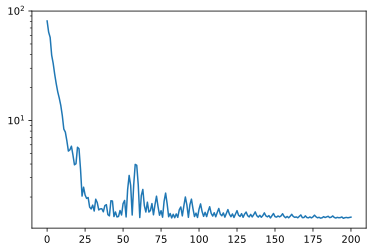

In [8]:
%%time
pyro.clear_param_store()
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
num_steps = 201
optim = ClippedAdam({"lr": 0.2, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

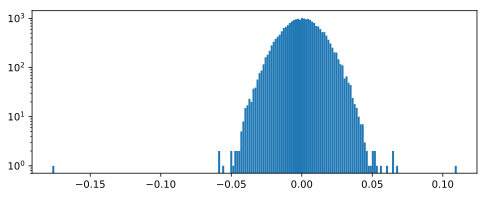

In [9]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(8, 3), dpi=300)
pyplot.hist(samples, bins=200)
pyplot.yscale('log')

This is a poor fit, but that's to be expected since we're mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, StudentT, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling in Pyro

Consider a stochastic volatity model of the log returns `r_t` and a latent volatility `h`:
$$
  \log h_t = \delta + \phi \log h_{t-1} + \sigma v_t \\
  r_t = w_t \sqrt{h_t}
$$
Usually $\sigma v_1$ and $w_t$ are both Gaussian. We will generalize to Student t and Stable distributions.

In [ ]:
class Process(dist.TorchDistribution):
    arg_constraints = {}
    def __init__(self, size, decay, trans_dist):
        self.decay = decay
        self.trans_dist = trans_dist
        batch_shape = trans_dist.batch_shape
        event_shape = (size,)
        super().__init__(batch_shape, event_shape)
    @property
    def support(self):
        return self.trans_dist.support
    def expand(self, shape):
        return Process(
            self.event_shape[0],
            self.decay,
            self.trans_dist.expand(shape))
    def log_prob(self, series):
        # Effectively unsqueeze self.trans_dist
        if isinstance(self.trans_dist, dist.Normal):
            trans_dist = dist.Normal(self.trans_dist.loc.unsqueeze(-1),
                                     self.trans_dist.scale.unsqueeze(-1))
        elif isinstance(self.trans_dist, dist.StudentT):
            trans_dist = dist.StudentT(self.trans_dist.df.unsqueeze(-1),
                                       self.trans_dist.loc.unsqueeze(-1),
                                       self.trans_dist.scale.unsqueeze(-1))
        else:
            raise NotImplementedError(type(self.trans_dist))
        diff = series[1:] - series[:-1] * self.decay
        return trans_dist.log_prob(diff).sum(-1)

class Model:
    def __init__(self, process_type="normal", obs_type="normal"):
        self.process_type = process_type
        self.obs_type = obs_type
        
    def __call__(self, data):
        # We experiment with three types of process noise.
        timescale = pyro.sample("timescale", dist.LogNormal(10, 3))
        h_decay = (-1 / timescale).exp()
        if self.process_type == "normal":
            h_dist = dist.Normal(0, timescale.rsqrt())
        elif self.process_type == "studentt":
            h_df = pyro.sample("h_df", dist.Gamma(3, 1))
            h_dist = dist.StudentT(h_df, 0, timescale.rsqrt())
        else:
            raise ValueError("unsupported process_type: {}".format(self.process_type))
        noise = pyro.sample("noise", Process(len(data), h_decay, h_dist))
        if noise.dim() >= 2:
            noise = noise.squeeze(-2)
        
        h_loc = pyro.sample("h_loc", dist.Normal(0, 3))
        h_scale = pyro.sample("h_scale", dist.LogNormal(-10, 3))
        log_h = h_loc + h_scale * noise

        # We experiment with two types of observation noise.
        r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2))
        r_scale = log_h.mul(0.5).exp()
        if self.obs_type == "normal":
            r_dist = dist.Normal(r_loc, r_scale)
        elif self.obs_type == "studentt":
            r_df = pyro.sample("r_df", dist.Gamma(3, 1))
            r_dist = dist.StudentT(r_df, r_loc, r_scale)
        elif self.obs_type == "stable":
            r_stability = pyro.sample("r_stability", dist.Uniform(0.5, 2.0))
            r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1))
            r_dist = dist.Stable(r_stability, r_skew, r_scale, r_loc)
        else:
            raise ValueError("unsupported obs_type: {}".format(self.obs_type))
        with pyro.plate("time", len(data)):
            r = pyro.sample("r", r_dist, obs=data)

        return log_h.detach(), r.detach()

In [ ]:
def init_loc_fn(site):
    inits = {
        "h_loc": r.std().log().mul(2),
        "timescale": torch.tensor(100.),
        "h_df": torch.tensor(10.),
        "h_scale": torch.tensor(1.),
        "r_df": torch.tensor(10.),
        "r_stability": torch.tensor(1.9),
        "r_skew": torch.tensor(0.),
        "r_loc": torch.tensor(0.),
    }
    if site["name"] in inits:
        return inits[site["name"]]
    return init_to_median(site)

In [ ]:
from pyro import poutine

@torch.no_grad()
def predict(model, guide, data):
    trace = poutine.trace(guide).get_trace(data)
    with poutine.replay(trace=trace), poutine.uncondition():
        return model(data)

predictions = {}

def add_prediction(model, guide, data):
    predictions[model.process_type, model.obs_type] = predict(model, guide, data)

In [ ]:
def train_elbo(model, num_steps=1001):
    pyro.clear_param_store()
    pyro.set_rng_seed(1234567890)
    pyro.enable_validation(True)
    guide = AutoDelta(model, init_loc_fn=init_loc_fn)
    # guide = AutoDiagonalNormal(model, init_loc_fn=init_loc_fn)
    # guide = AutoLowRankMultivariateNormal(model, init_loc_fn=init_loc_fn, rank=8)
    optim = ClippedAdam({
        "lr": 0.02,
        "betas": (0.9, 0.99),
        "lrd": 0.1 ** (1 / num_steps),
    })
    svi = SVI(model, guide, optim, Trace_ELBO())
    losses = []
    for step in range(num_steps):
        loss = svi.step(r)
        losses.append(loss)
        if step % 50 == 0:
            median = guide.median()
            print("step {} loss = {:0.6g}, timescale = {:0.3g}".format(
                step, loss, median["timescale"].item()))
    pyplot.plot(losses)
    for name, value in sorted(guide.median().items()):
        if value.numel() == 1:
            print("{} = {}".format(name, value.squeeze().item()))
    add_prediction(model, guide, r)

In [ ]:
%%time
model = Model("normal", "normal")
train_elbo(model, num_steps=1001)

In [ ]:
%%time
model = Model("normal", "studentt")
train_elbo(model)

In [ ]:
%%time
model = Model("studentt", "normal")
train_elbo(model)

In [ ]:
%%time
model = Model("studentt", "studentt")
train_elbo(model)

In [ ]:
def train_energy(model, num_steps=1001):
    pyro.clear_param_store()
    pyro.set_rng_seed(1234567890)
    pyro.enable_validation(True)
    guide = AutoDelta(model, init_loc_fn=init_loc_fn)
    # guide = AutoDiagonalNormal(model, init_loc_fn=init_loc_fn)
    # guide = AutoLowRankMultivariateNormal(model, init_loc_fn=init_loc_fn, rank=8)
    optim = ClippedAdam(lambda name, _: {
        "lr": 0.1 if name.startswith("Auto") else 0.01,
        "betas": (0.9, 0.99),
        "lrd": 0.1 ** (1 / num_steps),
    })
    svi = SVI(model, guide, optim, EnergyDistance(prior_scale=1/len(r)))
    losses = []
    for step in range(num_steps):
        loss = svi.step(r)
        losses.append(loss)
        if step % 50 == 0:
            median = guide.median()
            print("step {} loss = {:0.6g}, timescale = {:0.3g}".format(
                step, loss, median["timescale"].item()))
    pyplot.plot(losses)
    # pyplot.yscale('log')
    for name, value in sorted(guide.median().items()):
        if value.numel() == 1:
            print("{} = {}".format(name, value.squeeze().item()))
    add_prediction(model, guide, r)

In [ ]:
%%time
model = Model("normal", "normal")
train_energy(model)

In [ ]:
%%time
model = Model("normal", "stable")
train_energy(model)

In [ ]:
%debug

In [ ]:
%%time
model = Model("studentt", "stable")
train_energy(model)

In [ ]:
fig, axes = pyplot.subplots(1 + len(predictions),
                            figsize=(8.5, 2 * (1 + len(predictions))),
                            sharex=True)
axes[0].plot(r, "k", lw=0.2)
axes[0].set_ylabel("returns")
axes[0].set_xlim(0, len(r))
for key, ax in zip(sorted(predictions), axes[1:]):
    log_h, r_pred = predictions[key]
    # ax.plot(log_h.mul(0.5).exp(), lw=0.2)
    ax.plot(log_h, lw=0.2)
    ax.set_ylabel("-".join(key))
ax.set_xlabel("day")
pyplot.tight_layout()